https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import os
import json
from PIL import Image
from torchvision.models import resnet18
import torch.optim as optim
from torchvision import transforms, datasets
from torchsummary import summary

# Data Visulizers
import matplotlib.pyplot as plt
import cv2
import numpy as np 
#

# Learning Rate Scheduling
from torch.optim.lr_scheduler import StepLR
#

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
class CustomDataset(Dataset):
    def __init__(self, root, split, transform=None):
        self.root = root
        self.split = split
        self.transform = transform

        # Load data from the JSON file
        json_path = os.path.join(root + '/_annotations.coco.json')
        with open(json_path, 'r') as f:
            data = json.load(f)

        # Assuming the JSON structure is like {'images': [...], 'annotations': {...}}
        images_info = data['images']
        annotations_info = data['annotations']
        
        # Fix to 0 based class system
        labels = [ann['category_id'] - 1 for ann in annotations_info]
        
        

        # Get image paths and corresponding labels
        self.image_paths = [os.path.join(root, img_info['file_name']) for img_info in images_info]
        self.labels = [anno_info['category_id'] - 1 for anno_info in annotations_info]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load the image using image loading library PIL
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
directory = 'train/'
json_path = os.path.join(directory, '_annotations.coco.json')
with open(json_path, 'r') as f:
    data = json.load(f)

annotations_info = data['annotations']
zero = 0
one = 0
for ann in annotations_info:
    if ann['category_id'] - 1 == 0:
        zero += 1
    else:
        one += 1
print(f"No Tumor: {zero} Tumor:{one}")


No Tumor: 771 Tumor:731


In [4]:
#for name, param in model.named_parameters():
#    print(name, param.shape)
    
    
# Assuming your images are in the range [0, 255]
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2046, 0.2046, 0.2046], std=[0.2125, 0.2125, 0.2125]),
])

# Apply this transform when loading your dataset
train_dataset = CustomDataset(root='train', split='train', transform=transform)

In [5]:
'''
# Find Standard Deviation and Mean in the dataset

def calculate_mean_std(dataset):
    """Calculates mean and standard deviation across all channels of a dataset."""
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)  # Adjust batch size as needed

    mean = 0.
    std = 0.
    num_samples = 0.
    for data, _ in data_loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)  
        std += data.std(2).sum(0)
        num_samples += batch_samples

    mean /= num_samples
    std /= num_samples

    return mean, std

# Example usage (adjust dataset path and transform if needed)
transform = transforms.Compose([transforms.ToTensor()]) 
dataset = datasets.ImageFolder(root='train/', transform=transform)

calculated_mean, calculated_std = calculate_mean_std(dataset)
print("Calculated Mean:", calculated_mean)
print("Calculated Standard Deviation:", calculated_std)
'''

'\n# Find Standard Deviation and Mean in the dataset\n\ndef calculate_mean_std(dataset):\n    """Calculates mean and standard deviation across all channels of a dataset."""\n    \n    data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)  # Adjust batch size as needed\n\n    mean = 0.\n    std = 0.\n    num_samples = 0.\n    for data, _ in data_loader:\n        batch_samples = data.size(0)\n        data = data.view(batch_samples, data.size(1), -1)\n        mean += data.mean(2).sum(0)  \n        std += data.std(2).sum(0)\n        num_samples += batch_samples\n\n    mean /= num_samples\n    std /= num_samples\n\n    return mean, std\n\n# Example usage (adjust dataset path and transform if needed)\ntransform = transforms.Compose([transforms.ToTensor()]) \ndataset = datasets.ImageFolder(root=\'train/\', transform=transform)\n\ncalculated_mean, calculated_std = calculate_mean_std(dataset)\nprint("Calculated Mean:", calculated_mean)\nprint("Calculated Standard Devi

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Initialize your custom dataset
train_dataset = CustomDataset(root='train', split='train', transform=transforms.ToTensor())
test_dataset = CustomDataset(root='test', split='test', transform=transforms.ToTensor())
valid_dataset = CustomDataset(root='valid', split='valid', transform=transforms.ToTensor())

In [8]:
# Create DataLoader instances for training, testing, and validation sets
num_workers = 8
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=num_workers)

In [9]:
# Initialize the ResNet model
model = resnet18(weights=None, num_classes=2)  # Change num_classes to the actual number of classes in your dataset

model.conv1.weight = nn.Parameter(torch.nn.init.kaiming_normal_(torch.empty(64, 1, 7, 7)))
# Assuming 'input_data' is your input tensor
input_data = torch.rand((48, 1, 640, 640))  # Adjust 'batch_size' as needed


# Assuming 'model' and 'input_data' as defined earlier
output_logits = model(input_data)

# Print the shape of the logits
print("Logits Shape:", output_logits.shape)

Logits Shape: torch.Size([48, 2])


In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
model = model.to("cuda")  #model.to("cpu") if running on CPU
#summary(model, input_size=(1, 640, 640))


In [12]:
print("Min Label:", min(train_dataset.labels))
print("Max Label:", max(train_dataset.labels))

Min Label: 0
Max Label: 1


In [13]:
# Move model to the device
model = model.to(device)

## Train Model + Output Val_Accuracy Per EPOCH
#### Different learning rate tests
- 10 Epoch at lr = .0001  => 96%
<br> <br>
- 30 Epoch at lr = .00001 => 89%
<br> <br>
 > - 20 Epoch at lr = .001   => 98%
---
   **Epoch 2:**
   - Train Loss: 0.4101
   - Validation Accuracy: 54.65%
   
   **Epoch 10:**
   - Train Loss: 0.0144
   - Validation Accuracy: 96.34%
   
   **Epoch 14:**
   - Train Loss: 0.0006
   - Validation Accuracy: 98.14%

In [14]:
val_dataset = CustomDataset(root='valid', split='validation', transform=transforms.Compose([transforms.ToTensor()]))

batch_size = 48 # MODIFY NEXT TO TRY AND INCREASE ACCURACTY
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
#model.eval()

correct = 0
total = 0

'''
# Iterate over the validation dataset
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Update counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = correct / total
print(f'Accuracy on the validation set: {accuracy * 100:.2f}%')
'''

"\n# Iterate over the validation dataset\nwith torch.no_grad():\n    for images, labels in val_loader:\n        images, labels = images.to(device), labels.to(device)\n\n        # Forward pass\n        outputs = model(images)\n\n        # Get predictions\n        _, predicted = torch.max(outputs, 1)\n\n        # Update counts\n        total += labels.size(0)\n        correct += (predicted == labels).sum().item()\n\n# Calculate accuracy\naccuracy = correct / total\nprint(f'Accuracy on the validation set: {accuracy * 100:.2f}%')\n"

In [15]:
def evaluate_model(model, val_loader, criterion):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    accuracy = correct / total
    return val_loss, accuracy

In [16]:
threshold_accuracy = 0.97

scheduler = StepLR(optimizer, step_size=5, gamma=.1)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    # Training
    model.train()  # Set model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        
        optimizer.zero_grad()
        
        
        output = model(data)
        loss = criterion(output, target)
        
        
        loss.backward()
        optimizer.step()

        
    scheduler.step()
    
    # Validation
    val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
    
    if val_accuracy >= threshold_accuracy:
            print(f"Validation accuracy reached the threshold of {threshold_accuracy}. Stopping training.")
            break


    val_accuracy *= 100
    # Log validation metrics
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Loss: {loss.item():.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.2f}%, '
          f'Learning Rate: {optimizer.param_groups[0]["lr"]}')

Epoch [1/20], Loss: 0.8017, Val Loss: 0.4821, Val Accuracy: 75.06%, Learning Rate: 0.0001
Epoch [2/20], Loss: 0.3768, Val Loss: 1.0472, Val Accuracy: 57.34%, Learning Rate: 0.0001
Epoch [3/20], Loss: 0.4410, Val Loss: 1.0960, Val Accuracy: 64.80%, Learning Rate: 0.0001
Epoch [4/20], Loss: 0.1180, Val Loss: 0.6977, Val Accuracy: 64.34%, Learning Rate: 0.0001
Epoch [5/20], Loss: 0.0357, Val Loss: 1.9068, Val Accuracy: 58.74%, Learning Rate: 1e-05
Epoch [6/20], Loss: 0.0130, Val Loss: 0.4538, Val Accuracy: 78.32%, Learning Rate: 1e-05
Epoch [7/20], Loss: 0.0196, Val Loss: 0.1167, Val Accuracy: 96.97%, Learning Rate: 1e-05
Validation accuracy reached the threshold of 0.97. Stopping training.


In [17]:
validation_loss, validation_accuracy = evaluate_model(model, val_loader, criterion)

print("Validation Loss: {:.4f}".format(validation_loss))
print("Validation Accuracy: {:.2f}%".format(validation_accuracy * 100))

Validation Loss: 0.1108
Validation Accuracy: 97.44%


## Data Visulizers

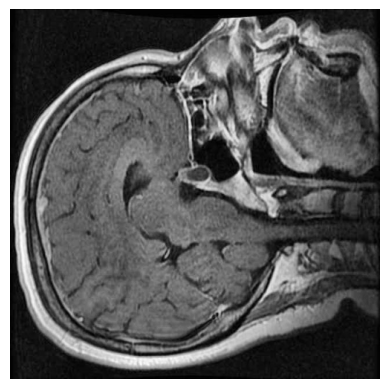

True Label: 2
Predicted Label: 2


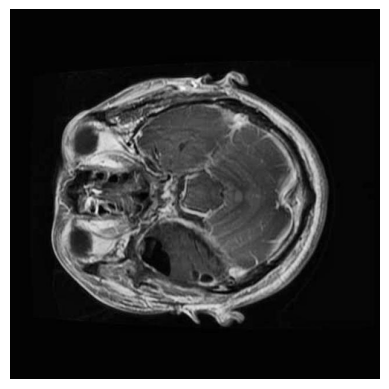

True Label: 1
Predicted Label: 2


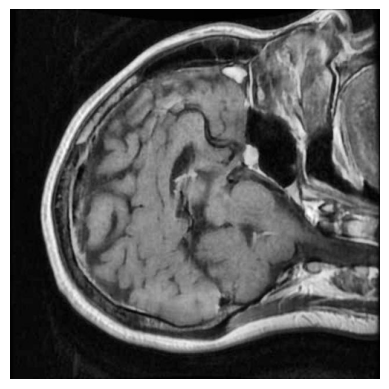

True Label: 2
Predicted Label: 2


In [18]:
def display_image(image):
    image = image.cpu().numpy()  # Move tensor to CPU and convert to numpy
    plt.imshow(image.squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
    plt.axis('off')
    plt.show()

def visualize_images(model, images, true_labels, num_images=3):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()

    # Randomly select 3 indices
    indices = np.random.choice(len(images), num_images, replace=False)

    for i in indices:

        image = images[i]
        true_label = true_labels[i]

        # Conversion, Normalization, and Model Inference
        if isinstance(image, Image.Image):
            image = np.array(image)

        # Ensure image is grayscale and resize if needed
        if len(image.shape) == 3:
            image = np.mean(image, axis=2)  # Convert to grayscale

        image_tensor = torch.from_numpy(image).float().div(255).unsqueeze(0).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(image_tensor)

        # Process outputs
        predicted = torch.argmax(outputs.data, 1).cpu().numpy()[0] + 1  # Adjust predicted label to start from 1

        # Display
        display_image(image_tensor.squeeze())
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {predicted}")

# Load data
json_path = os.path.join('train', '_annotations.coco.json')
with open(json_path, 'r') as f:
    data = json.load(f)       

annotations_info = data['annotations']
labels = [ann['category_id'] for ann in annotations_info]

directory = 'train/'               
image_paths = [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.endswith('.jpg')]

# Load images
images = [Image.open(path).convert('L') for path in image_paths]  # Example with PIL

# Visualize
visualize_images(model, images, labels, num_images=3)

In [19]:
'''
file_path = 'test/_annotations.coco.json'
with open(file_path, 'r') as file:  
    json_data = json.load(file) 
json_data
'''

"\nfile_path = 'test/_annotations.coco.json'\nwith open(file_path, 'r') as file:  \n    json_data = json.load(file) \njson_data\n"